In [6]:
import rasterio
from rasterio import mask
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import os
from skimage import exposure
from shapely.geometry import box,Polygon
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches

# Stacking the raster bands

In [7]:
import svdclustering

In [8]:
raster,raster_arr=svdclustering.stackingfiles(path_to_folder='EO1H0350252010205110KU_1T',stacking_filename='stacked_raster_dataset3.tif')

# Display the raster

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Original image')

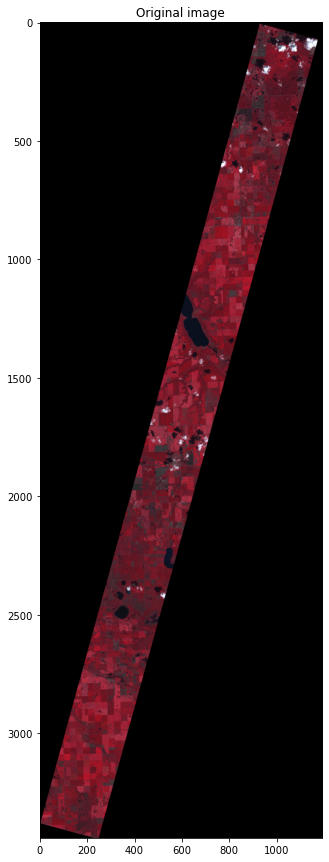

In [10]:
# plot the raster image
rasterimage=np.dstack((raster_arr[39,:,:],raster_arr[31,:,:],raster_arr[23,:,:]))
#rasterimage = exposure.equalize_hist(rasterimage)
fig = plt.figure(figsize = (15,15))
plt.imshow(rasterimage/8665)
plt.title('Original image')

# Clipping the raster file.

In [16]:
b = box(584993.703,5566045.59785453,588980.352936682,5579271.753)
poly=[b]

In [17]:
import clipRaster
clipped_array=svdclustering.clippingRasterfile(input_raster='stacked_raster_dataset3.tif',output_clipped_filename='clipped_raster_vegitationregion.tiff',polygonarray=poly)

Text(0.5, 1.0, 'raster subset')

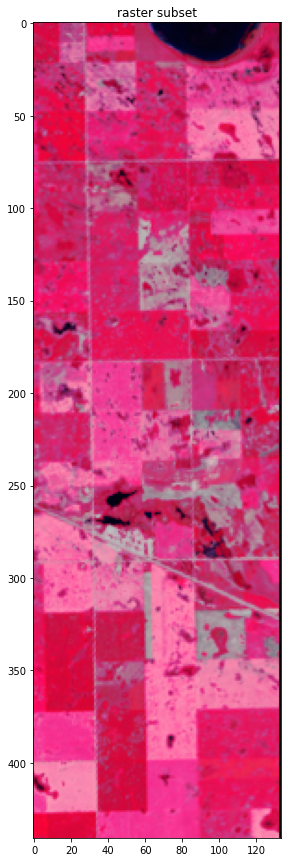

In [18]:

# plot the raster image
rasterimage=np.dstack((clipped_array[39,:,:],clipped_array[31,:,:],clipped_array[23,:,:]))
fig = plt.figure(figsize = (15,15))
rasterimage = exposure.equalize_hist(rasterimage)
plt.imshow(rasterimage)
plt.title('raster subset')

In [14]:
raster = rasterio.open('clipped_raster_vegitationregion.tif')
clipped_array = raster.read()
   

In [7]:
np.max(clipped_array)

8665

In [15]:
raster.bounds

BoundingBox(left=584993.703, bottom=5566045.59785453, right=588980.352936682, top=5579271.753)

#  Dimensionality reduction using SVD and clustering using Kmeans

In [19]:
#removing unwanted bands
selectedband_indicies=np.concatenate((np.arange(8,57, 1),np.arange(77, 224, 1)),axis=0)
clipped_array=clipped_array[selectedband_indicies,:,:]

In [26]:

svd_output,labeloutput=svdclustering.SVDTruncated_kmeans(input_array=clipped_array,components_count=10,clusterCount=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, ' SVD on subset')

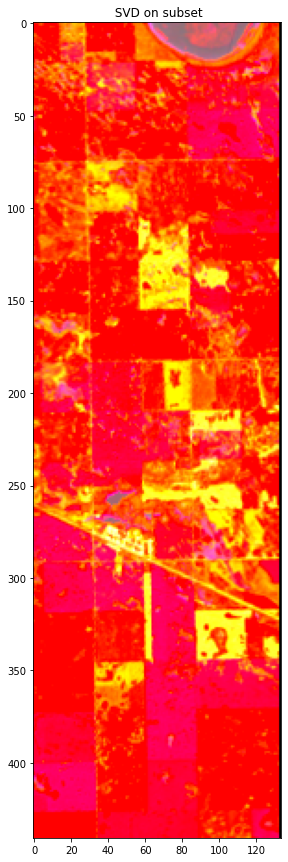

In [27]:
raster_show=np.dstack((svd_output[:,:,0],svd_output[:,:,1],svd_output[:,:,2]))
fig = plt.figure(figsize = (15,15))
plt.imshow(raster_show/5816)
plt.title(' SVD on subset')

In [29]:
labeloutput[labeloutput==1]=0
labeloutput[labeloutput==3]=0
labeloutput[labeloutput==2]=1
#labeloutput[labeloutput==3]=2

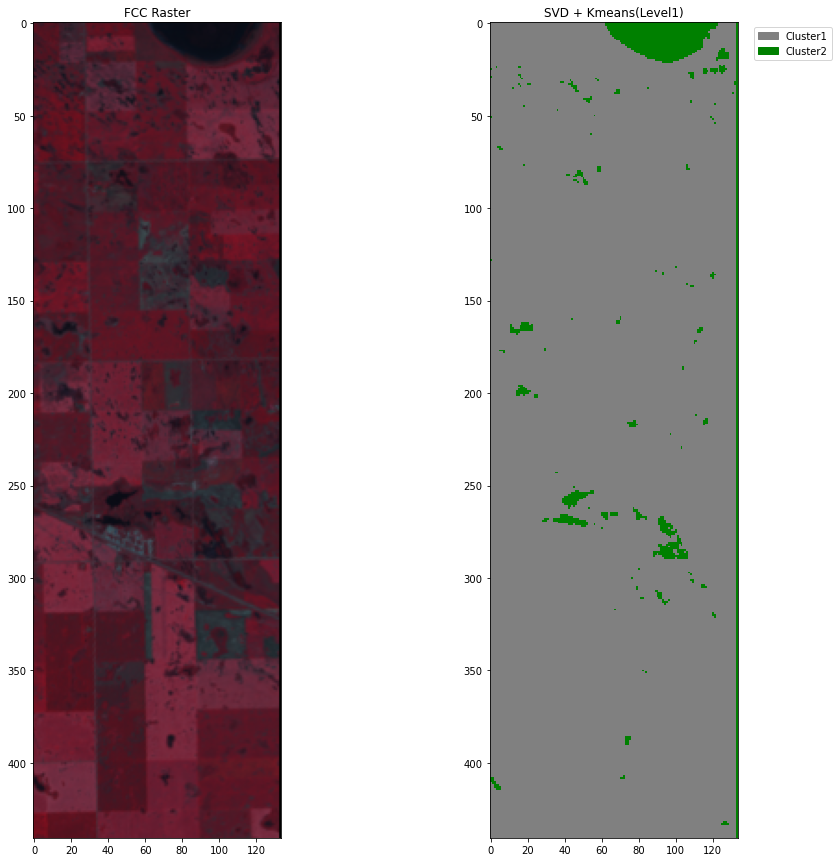

In [30]:
rasterimage=np.dstack((clipped_array[32,:,:],clipped_array[25,:,:],clipped_array[16,:,:]))
svdclustering.visualize_image(labeloutput,rasterimage/8665,"FCC Raster","SVD + Kmeans(Level1)")

In [23]:
#class wise pixel count

In [31]:
classcount=3
for i in range(classcount):
    class1_pixels=np.argwhere(labeloutput==i)
    class_count=len(class1_pixels)
    print("No of pixels for cluster "+str(i+1)+" is "+str(class_count))

No of pixels for cluster 1 is 56959
No of pixels for cluster 2 is 2135
No of pixels for cluster 3 is 0


# Second level clustering

In [32]:
labeloutput_secondlevel=svdclustering.SVDTruncated_level2_kmeans(input_array=clipped_array,components_count=20,cluster=0,labels=labeloutput,clusterCount=3)

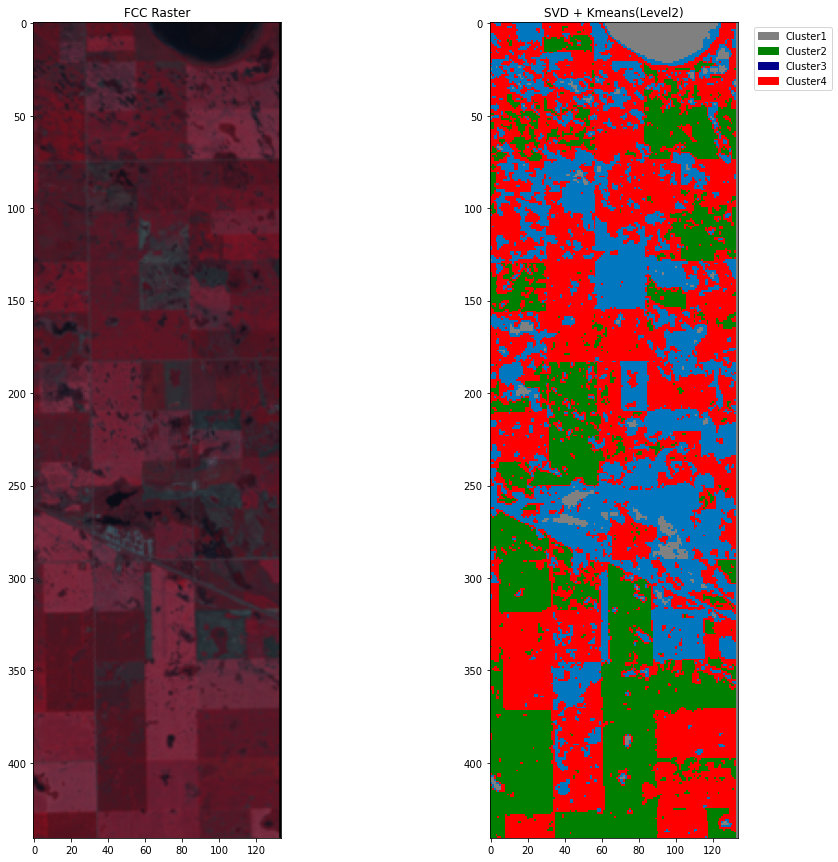

In [33]:
svdclustering.visualize_image(labeloutput_secondlevel,rasterimage/8665,"FCC Raster","SVD + Kmeans(Level2)")

In [34]:
classcount=4
for i in range(1,classcount):
    class1_pixels=np.argwhere(labeloutput_secondlevel==i)
    class_count=len(class1_pixels)
    print("No of pixels for cluster "+str(i+1)+" is "+str(class_count))

No of pixels for cluster 2 is 14763
No of pixels for cluster 3 is 15637
No of pixels for cluster 4 is 26559


# Cumulative Results and Analysis

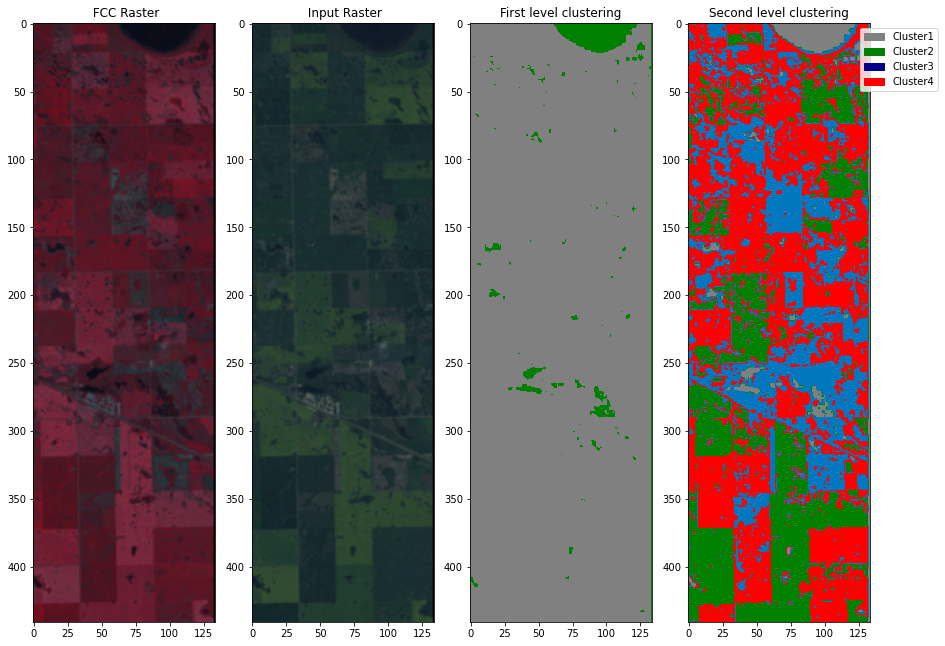

In [58]:
fig = plt.figure(figsize = (15,15))
columns = 4
rows = 1
#rasterimage=np.dstack((clipped_array[32,:,:],clipped_array[25,:,:],clipped_array[16,:,:]))
#rasterimage = exposure.equalize_hist(rasterimage)
fig.add_subplot(rows, columns, 1)
plt.imshow(rasterimage/8665)

plt.title(' FCC Raster')
rasterimage=np.dstack((clipped_array[22,:,:],clipped_array[13,:,:],clipped_array[5,:,:]))
fig.add_subplot(rows, columns, 2)
plt.imshow(rasterimage/8665)
plt.title(' Input Raster')
level1_labelimage=labeloutput
fig.add_subplot(rows, columns, 3)
plt.imshow(level1_labelimage,cmap=svdclustering.CMAP(level1_labelimage))
plt.title('First level clustering')
level2_labelimage=labeloutput_secondlevel
fig.add_subplot(rows, columns, 4)
plt.imshow(level2_labelimage,cmap=svdclustering.CMAP(level2_labelimage))
plt.title('Second level clustering')
gray_patch = mpatches.Patch(color='Gray', label='Cluster1')
green_patch = mpatches.Patch(color='Green', label='Cluster2')
blue_patch = mpatches.Patch(color='Darkblue', label='Cluster3')
red_patch = mpatches.Patch(color='Red', label='Cluster4')
yellow_patch = mpatches.Patch(color='Yellow', label='Cluster5')
colorlist=[gray_patch,green_patch,blue_patch,red_patch,yellow_patch]
plt.legend(loc='upper right',handles=colorlist[0:4],bbox_to_anchor=(1.4, 1))
plt.show()

# Using Autoencoder for feature reduction and Kmeans for clustering

In [36]:
import autoencoder
# reshaping the data from (bands,rows,columns) to (rows, columns, bands)
row, col, bands = int(clipped_array.shape[1]), int(clipped_array.shape[2]),int(clipped_array.shape[0])
input_data=np.ndarray(shape=(row,col,bands))
for j in range(bands):
    input_data[:,:,j]=clipped_array[j,:,:]
    #reshape row* columns *bands to 1d*bands
reshape_inputdata=input_data.reshape(input_data.shape[0]*input_data.shape[1],input_data.shape[2])
reshape_inputdata_tofloat = (reshape_inputdata/ 5816.0).astype('float32') 

Using TensorFlow backend.
C:\Users\Geokno\Anaconda3\envs\newaswork\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Geokno\Anaconda3\envs\newaswork\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Geokno\Anaconda3\envs\newaswork\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Geokno\Anaconda3\envs\n

In [37]:
# shuffling the data
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)
suffled_inputdata=shuffle_along_axis(reshape_inputdata_tofloat, axis=0)

In [38]:
traintest_splitcount=int(0.75*suffled_inputdata.shape[0])

In [39]:
import autoencoder
# dimensionality reduction using autoencoders
autoencoderlevel1,encoder=autoencoder.autoencoder_dimensionaltyReduction(suffled_inputdata.shape[1])
# compiling and fitting
autoencoderlevel1.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoderlevel1.fit(suffled_inputdata[0:traintest_splitcount], suffled_inputdata[0:traintest_splitcount],
                epochs=10,
                batch_size=1000,
                shuffle=True,
                validation_data=(suffled_inputdata[traintest_splitcount:], suffled_inputdata[traintest_splitcount:]))
# encoder outputs -- reduced features
encoded_outputs = encoder.predict(reshape_inputdata_tofloat)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 44320 samples, validate on 14774 samples
Epoch 1/10
44320/44320 [==============================] - 1s 32us/step - loss: 0.5638 - val_loss: 0.3507
Epoch 2/10
44320/44320 [==============================] - 1s 23us/step - loss: 0.3450 - val_loss: 0.3437
Epoch 3/10
44320/44320 [==============================] - 1s 22us/step - loss: 0.3432 - val_loss: 0.3432
Epoch 4/10
44320/44320 [==============================] - 1s 22us/step - loss: 0.3430 - val_loss: 0.3431
Epoch 5/10
44320/44320 [==============================] - 1s 21us/step - loss: 0.3429 - val_loss: 0.3430
Epoch 6/10
44320/44320 [==============================] - 1s 22us/step - loss: 0.3428 - val_loss: 0.3430
Epoch 7/10
44320/44320 [==============================] - 1s 22us/step - loss: 0.3428 - val_loss: 0.3430
Epoch 8/10
44320/44320 [==============================] - 1s 22us/step - loss: 0.3428 - val_los

In [41]:
# clustering the reduced features
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(encoded_outputs)
labels_autoencoder=kmeans.labels_

In [43]:
labels_autoencoder[labels_autoencoder==3]=0

labels_autoencoder[labels_autoencoder==1]=0
labels_autoencoder[labels_autoencoder==2]=1
#labels_autoencoder[labels_autoencoder==3]=0

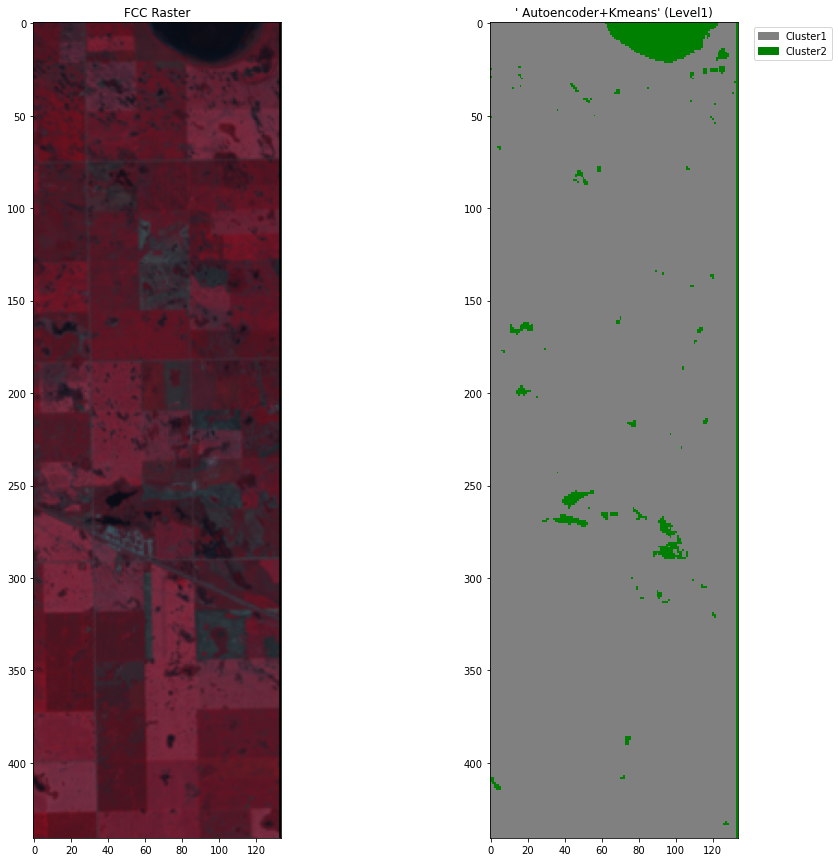

In [44]:
labels_autoencoder_output=labels_autoencoder.reshape(int(clipped_array.shape[1]), int(clipped_array.shape[2]),)
svdclustering.visualize_image(labels_autoencoder_output,rasterimage/8665,"FCC Raster","' Autoencoder+Kmeans' (Level1)")

In [45]:
classcount=3
for i in range(classcount):
    class1_pixels=np.argwhere(labels_autoencoder_output==i)
    class_count=len(class1_pixels)
    print("No of pixels for cluster "+str(i+1)+" is "+str(class_count))

No of pixels for cluster 1 is 57081
No of pixels for cluster 2 is 2013
No of pixels for cluster 3 is 0


# Second level clustering using Autoencoder and Kmeans

In [46]:
class_addresses=np.argwhere(labels_autoencoder==0)
class_pixels=[]
for i in class_addresses:
    class_pixels.append(reshape_inputdata_tofloat[i[0]])
class_pixels=np.array(class_pixels)

In [47]:
class_pixels.shape

(57081, 196)

In [48]:
traintest_splitcount=int(0.75*class_pixels.shape[0])

In [49]:
import autoencoder# dimensionality reduction using autoencoders

autoencoder_level2,encoder_level2=autoencoder.autoencoder_dimensionaltyReduction(class_pixels.shape[1])
# compiling and fitting
autoencoder_level2.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder_level2.fit(class_pixels[0:traintest_splitcount], class_pixels[0:traintest_splitcount],
                epochs=10,
                batch_size=1000,
                shuffle=True,
                validation_data=(class_pixels[traintest_splitcount:], class_pixels[traintest_splitcount:]))
# encoder outputs -- reduced features
autoencoder_level2 = encoder.predict(class_pixels)

Train on 42810 samples, validate on 14271 samples
Epoch 1/10
42810/42810 [==============================] - 1s 31us/step - loss: 0.5800 - val_loss: 0.3409
Epoch 2/10
42810/42810 [==============================] - 1s 24us/step - loss: 0.3516 - val_loss: 0.3264
Epoch 3/10
42810/42810 [==============================] - 1s 21us/step - loss: 0.3484 - val_loss: 0.3261
Epoch 4/10
42810/42810 [==============================] - 1s 21us/step - loss: 0.3480 - val_loss: 0.3255
Epoch 5/10
42810/42810 [==============================] - 1s 21us/step - loss: 0.3478 - val_loss: 0.3260
Epoch 6/10
42810/42810 [==============================] - 1s 21us/step - loss: 0.3477 - val_loss: 0.3257
Epoch 7/10
42810/42810 [==============================] - 1s 22us/step - loss: 0.3477 - val_loss: 0.3257
Epoch 8/10
42810/42810 [==============================] - 1s 21us/step - loss: 0.3476 - val_loss: 0.3262
Epoch 9/10
42810/42810 [==============================] - 1s 21us/step - loss: 0.3476 - val_loss: 0.3260
Epoch

In [50]:
#reshapeimage1 = reshapeimage.astype('float32') / 5816.0

In [51]:
encoded_outputs_secondlevel = encoder_level2.predict(class_pixels)
kmeans = KMeans(n_clusters=3, random_state=0).fit(encoded_outputs_secondlevel)
labels_autoencoder_2ndlevel=kmeans.labels_
secondlevel_labeloutputs=np.zeros((int(clipped_array.shape[1])*int(clipped_array.shape[2])))
j=0;
for i in class_addresses:
    secondlevel_labeloutputs[i[0]]=labels_autoencoder_2ndlevel[j]+1
    j=j+1;
outputs_level2_autoencoder=secondlevel_labeloutputs.reshape(int(clipped_array.shape[1]),int(clipped_array.shape[2]),)

In [52]:

svdclustering.visualize_image(outputs_level2_autoencoder,rasterimage/8665,"FCC Raster","' Autoencoder+Kmeans' (Level2)")

In [53]:
classcount=4
for i in range(1,classcount):
    class1_pixels=np.argwhere(outputs_level2_autoencoder==i)
    class_count=len(class1_pixels)
    print("No of pixels for cluster "+str(i+1)+" is "+str(class_count))

No of pixels for cluster 2 is 12883
No of pixels for cluster 3 is 28694
No of pixels for cluster 4 is 15504


# Cumulative Results and Analysis

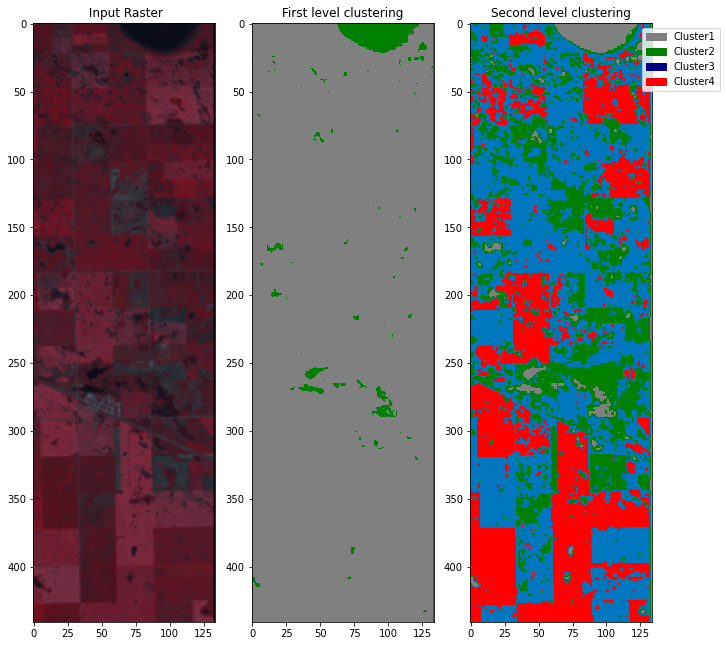

In [54]:
fig = plt.figure(figsize = (15,15))
columns = 4
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(rasterimage/8665)
plt.title(' Input Raster')
fig.add_subplot(rows, columns, 2)
plt.imshow(labels_autoencoder_output,cmap=svdclustering.CMAP(labels_autoencoder_output))
plt.title('First level clustering')
fig.add_subplot(rows, columns, 3)
plt.imshow(outputs_level2_autoencoder,cmap=svdclustering.CMAP(outputs_level2_autoencoder))
plt.title('Second level clustering')
gray_patch = mpatches.Patch(color='Gray', label='Cluster1')
green_patch = mpatches.Patch(color='Green', label='Cluster2')
blue_patch = mpatches.Patch(color='Darkblue', label='Cluster3')
red_patch = mpatches.Patch(color='Red', label='Cluster4')
yellow_patch = mpatches.Patch(color='Yellow', label='Cluster5')
colorlist=[gray_patch,green_patch,blue_patch,red_patch,yellow_patch]
plt.legend(loc='upper right',handles=colorlist[0:4],bbox_to_anchor=(1.4, 1))
plt.show()

# Comparision of different feature reduction techniques

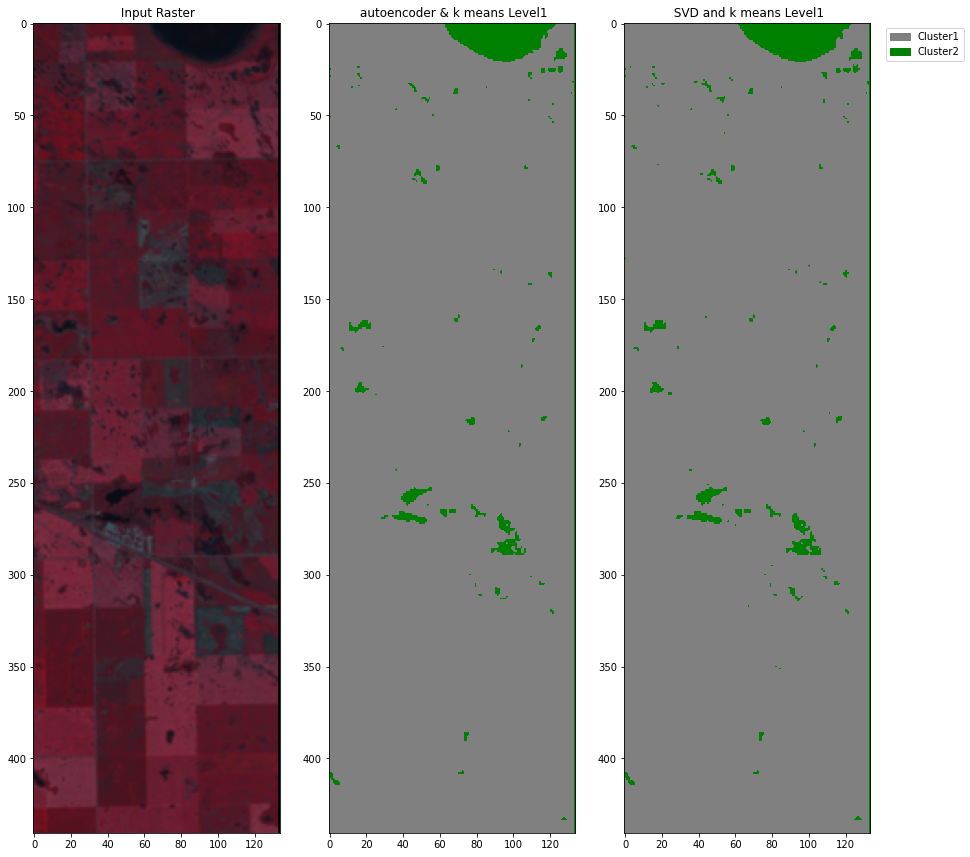

In [55]:
# level 1 features comparision
fig = plt.figure(figsize = (15,15))
columns = 3
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(rasterimage/8665)
plt.title(' Input Raster')
#svdkmeans_level1=labels_autoencoder_output
fig.add_subplot(rows, columns, 2)
plt.imshow(labels_autoencoder_output,cmap=svdclustering.CMAP(labels_autoencoder_output))
plt.title(' autoencoder & k means Level1')
#autoencoderkmeans_level1=labeloutput
fig.add_subplot(rows, columns, 3)
plt.imshow(labeloutput,cmap=svdclustering.CMAP(labeloutput))
plt.title(' SVD and k means Level1')
gray_patch = mpatches.Patch(color='Gray', label='Cluster1')
green_patch = mpatches.Patch(color='Green', label='Cluster2')
blue_patch = mpatches.Patch(color='Darkblue', label='Cluster3')
red_patch = mpatches.Patch(color='Red', label='Cluster4')
yellow_patch = mpatches.Patch(color='Yellow', label='Cluster5')
colorlist=[gray_patch,green_patch,blue_patch,red_patch,yellow_patch]
plt.legend(loc='upper right',handles=colorlist[0:2],bbox_to_anchor=(1.4, 1))
plt.show()

In [57]:
# level2 features comparision
fig = plt.figure(figsize = (15,15))
columns = 4
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(rasterimage/8665)
plt.title(' Input Raster')
level2_labelimage=outputs_level2_autoencoder
fig.add_subplot(rows, columns, 2)
plt.imshow(outputs_level2_autoencoder,cmap=svdclustering.CMAP(outputs_level2_autoencoder))
plt.title('autoencoder & k means Level 2')
level2_labelimage=labeloutput_secondlevel
fig.add_subplot(rows, columns, 3)
plt.imshow(labeloutput_secondlevel,cmap=svdclustering.CMAP(labeloutput_secondlevel))
plt.title('SVD and k means Level 2')
gray_patch = mpatches.Patch(color='Gray', label='Cluster1')
green_patch = mpatches.Patch(color='Green', label='Cluster2')
blue_patch = mpatches.Patch(color='Darkblue', label='Cluster3')
red_patch = mpatches.Patch(color='Red', label='Cluster4')
yellow_patch = mpatches.Patch(color='Yellow', label='Cluster5')
colorlist=[gray_patch,green_patch,blue_patch,red_patch,yellow_patch]
plt.legend(loc='upper right',handles=colorlist[0:4],bbox_to_anchor=(1.4, 1))
plt.show()